# Clustering in PySpark's MLlib Project Solution

**Project Title:** University Clustering for the Greater Good

**Objective**

You are a data scientist employed by the ABCDE Foundation, a non-profit organization whose mission is to increase college graduation rates for underpriveleged populations. Through advocacy and targeted outreach programs, ABCDE strives to identify and alleviate barriers to educational achievement. ABCDE is driven by the belief that with the right supports, an increase in college attendance and completion rates can be achieved, thereby weakening the grip of the cycles of poverty and social immobility affecting many of our communities.

ABCDE is committed to developing a more data driven approach to decision making. As a prelude to future analyses, ABCDE has requested that you analyze the data to identify clusters of similar colleges and universities.

**Your Task**

Use cluster analysis to identify the groups of characteristically similar schools in the CollegeScorecard.csv dataset.

## Considerations:

 - Data Preparation 
 - How will you deal with missing values? 
 - Categorical variables? 
 - Hyperparameter optimization?

These are the (sometimes subjective) questions you need to figure out as a data scientist. It's highly recommended to familiarize yourself with the dataset's dictionary and documentation, as well as the theory and technical characteristics of the algorithm(s) you're using.

**Interpretation**

Is it possible to explain what each cluster represents? Did you retain or prepare a set of features that enables a meaningful interpretation of the clusters? Do the compositions of the clusters seem to make sense?

The CollegeScoreCardDataDictionary-09-12-2015.csv file attached will also help with this part.

**Validation**

How will you measure the validity of your clustering process? Which metrics will you use and how will you apply them?

*Important Note*

This is an open-ended assignment (as many or most real-life data science projects are). Your only constraints are that you must use the data provided, execute high-quality and justifiable clustering technique, provide your rationale for the decisions you made, and ultimately produce meaningful cluster labels.

**Deliverables:**

An array of cluster labels corresponding to UNITID (the unique college/university I.D. variable).

**Source:** https://data.world/exercises/cluster-analysis-exercise-2

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Clustering_Project").getOrCreate()

In [11]:
import numpy as np
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

#from mpl_toolkits.mplot3d import Axes3D

In [3]:
df = spark.read.csv('Datasets/CollegeScorecard.csv',inferSchema=True,header=True)
df.limit(5).toPandas()

,UNITID,OPEID,opeid6,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,NPCURL,...,COMPL_RPY_3YR_RT_SUPP,NONCOM_RPY_3YR_RT_SUPP,DEP_RPY_3YR_RT_SUPP,IND_RPY_3YR_RT_SUPP,PELL_RPY_3YR_RT_SUPP,NOPELL_RPY_3YR_RT_SUPP,FEMALE_RPY_3YR_RT_SUPP,MALE_RPY_3YR_RT_SUPP,FIRSTGEN_RPY_3YR_RT_SUPP,NOTFIRSTGEN_RPY_3YR_RT_SUPP
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,galileo.aamu.edu/netpricecalculator/npcalc.htm,...,0.578873239,0.373790022,0.442857143,0.45890411,0.443586698,0.452513966,0.484818805,0.406,0.423580786,0.44245283
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,www.uab.edu,www.collegeportraits.org/AL/UAB/estimator/agree,...,0.847800926,0.678748759,0.767798013,0.739164697,0.732297853,0.795454545,0.760521886,0.755344418,0.751552795,0.765074771
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,www.amridgeuniversity.edu,tcc.noellevitz.com/(S(miwoihs5stz5cpyifh4nczu0...,...,0.807692308,0.61328125,PrivacySuppressed,0.641114983,0.600877193,0.775,0.610465116,0.686567164,0.632653061,0.65
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu,finaid.uah.edu/,...,0.892045455,0.689788054,0.800347222,0.75564409,0.738341969,0.851405622,0.768378651,0.79844098,0.778156997,0.791666667
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/email/index.aspx,www.alasu.edu/cost-aid/forms/calculator/index....,...,0.482490272,0.315996848,0.32410212,0.350993377,0.320016821,0.380829016,0.364423718,0.286530612,0.315737052,0.334633385


In [4]:
df.count()

7804

In [5]:
len(df.columns)

1725

In [7]:
from pyspark.sql.functions import *
def fill_with_mean(df, include=set()): 
    stats = df.agg(*(
        avg(c).alias(c) for c in df.columns if c in include
    ))
    return df.na.fill(stats.first().asDict())

input_columns = []
for column in df.columns:
    if str(df.schema[column].dataType) in('IntegerType','DoubleType'):
        input_columns.append(column)

df = fill_with_mean(df, input_columns)
df.limit(5).toPandas()

,UNITID,OPEID,opeid6,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,NPCURL,...,COMPL_RPY_3YR_RT_SUPP,NONCOM_RPY_3YR_RT_SUPP,DEP_RPY_3YR_RT_SUPP,IND_RPY_3YR_RT_SUPP,PELL_RPY_3YR_RT_SUPP,NOPELL_RPY_3YR_RT_SUPP,FEMALE_RPY_3YR_RT_SUPP,MALE_RPY_3YR_RT_SUPP,FIRSTGEN_RPY_3YR_RT_SUPP,NOTFIRSTGEN_RPY_3YR_RT_SUPP
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,galileo.aamu.edu/netpricecalculator/npcalc.htm,...,0.578873239,0.373790022,0.442857143,0.45890411,0.443586698,0.452513966,0.484818805,0.406,0.423580786,0.44245283
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,www.uab.edu,www.collegeportraits.org/AL/UAB/estimator/agree,...,0.847800926,0.678748759,0.767798013,0.739164697,0.732297853,0.795454545,0.760521886,0.755344418,0.751552795,0.765074771
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,www.amridgeuniversity.edu,tcc.noellevitz.com/(S(miwoihs5stz5cpyifh4nczu0...,...,0.807692308,0.61328125,PrivacySuppressed,0.641114983,0.600877193,0.775,0.610465116,0.686567164,0.632653061,0.65
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu,finaid.uah.edu/,...,0.892045455,0.689788054,0.800347222,0.75564409,0.738341969,0.851405622,0.768378651,0.79844098,0.778156997,0.791666667
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/email/index.aspx,www.alasu.edu/cost-aid/forms/calculator/index....,...,0.482490272,0.315996848,0.32410212,0.350993377,0.320016821,0.380829016,0.364423718,0.286530612,0.315737052,0.334633385


In [9]:
vecAssembler = VectorAssembler(inputCols=input_columns, outputCol="features")
final_df = vecAssembler.transform(df).select('UNITID', 'features')
final_df.show(5)

+------+--------------------+
|UNITID|            features|
+------+--------------------+
|100654|(377,[0,1,2,4,5,6...|
|100663|(377,[0,1,2,4,5,6...|
|100690|(377,[0,1,2,4,5,6...|
|100706|(377,[0,1,2,4,5,6...|
|100724|(377,[0,1,2,4,5,6...|
+------+--------------------+
only showing top 5 rows



With k = 2, silhouette is = 0.9636857880189782
With k = 3, silhouette is = 0.9126026550383612
With k = 4, silhouette is = 0.9734705487587858
With k = 5, silhouette is = 0.9673140583038164
With k = 6, silhouette is = 0.9646116089506219


Text(0, 0.5, 'silhouette')

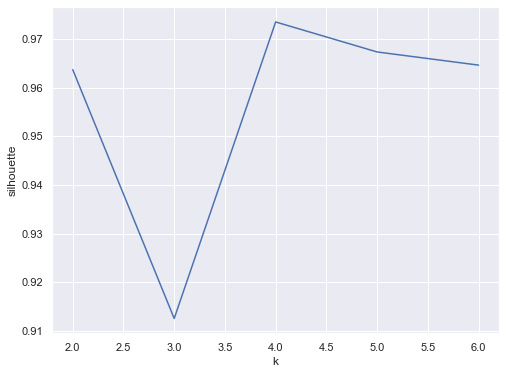

In [18]:
kmax = 8
cost = np.zeros(kmax)
for k in range(2,kmax):
    kmeans = KMeans(initSteps=4, tol=1e-4, maxIter=20).setK(k).setSeed(42).setFeaturesCol("features")
    model = kmeans.fit(final_df.sample(False,0.1, seed=42))
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(model.transform(final_df))
    print('With k = {}, silhouette is = {}'.format(k,silhouette))
    cost[k] = silhouette

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,kmax),cost[2:kmax])
ax.set_xlabel('k')
ax.set_ylabel('silhouette')

In [15]:
k = 4
kmeans = KMeans().setK(k).setSeed(42).setFeaturesCol("features")
model = kmeans.fit(final_df)
predictions = model.transform(final_df)

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.973382446581744
 
Cluster Centers: 
[ 2.81679837e+05  1.71173483e+06  1.62297053e+04  8.87614366e-03
  7.78642633e-01  6.93404342e+00  1.88310802e+00  2.28854295e+00
  2.19431927e+00  2.91824389e+01  4.60617233e+00  1.96250171e+01
  3.74926822e+01 -9.03181977e+01  1.53846784e+01  5.44967909e+00
  6.41417452e+00  1.35190496e-02  4.77946197e-03  1.36556056e-03
  4.64290591e-03  1.91178479e-03  1.80253994e-02  1.77522873e-03
  9.14925577e-03  5.87191042e-03  5.40699167e+01  6.82431757e-01
  6.88713507e-01  4.67069644e+02  5.76030725e+02  4.76100369e+02
  5.84164277e+02  4.68007237e+02  5.74038645e+02  5.21144340e+02
  5.30138604e+02  5.21025946e+02  2.00669125e+01  2.50715554e+01
  1.90624061e+01  2.50898539e+01  1.90742865e+01  2.50307251e+01
  6.02621876e+00  8.01870818e+00  2.30221221e+01  2.21152533e+01
  2.20931312e+01  7.03017889e+00  1.05613369e+03  1.06124102e+03
  3.96790818e-03  2.68438953e-03  1.50851964e-03  1.28050232e-03
  1.169

## Describe the clusters in lamens terms

What are some defining characteristics of each cluster? Try to use some of the variables to explain to the client. 

In [19]:
# First get the centers of each cluster
centers = model.clusterCenters()

# Then map the centers to their variable names
import pandas as pd
import numpy as np
center_pdf = pd.DataFrame(list(map(np.ravel,centers)))
center_pdf.columns = input_columns
center_pdf

,UNITID,OPEID,opeid6,HCM2,main,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,st_fips,...,RET_PT4,RET_PTL4,C200_4_POOLED,C200_L4_POOLED,poolyrs200,D200_4_POOLED,D200_L4_POOLED,PCTFLOAN,UG25abv,CDR3
0,2.816798e+05,1.711735e+06,16229.705312,0.008876,0.778643,6.934043,1.883108,2.288543,2.194319,29.182439,...,0.4493,0.558225,0.491768,0.593543,2.140107,1230.340571,687.13997,0.530181,0.417572,0.125960
1,4.414783e+05,4.443218e+07,20988.000000,0.000000,0.000000,71.000000,2.850000,3.750000,3.000000,30.516667,...,0.4493,0.558225,0.216137,0.593543,2.066667,462.816667,687.00000,0.655852,0.867258,0.190000
2,4.393810e+07,2.263500e+06,16974.383648,0.025157,0.012579,43.440252,0.000000,0.000000,2.798742,27.962264,...,0.4493,0.558225,0.489528,0.593543,2.000000,1224.000000,687.00000,0.531202,0.421227,0.157415
3,1.615950e+07,1.145834e+06,11458.251908,0.000000,0.019084,11.835878,0.000000,0.000000,2.301527,23.038168,...,0.4493,0.558225,0.489528,0.593543,2.000000,1224.000000,687.00000,0.531202,0.421227,0.157115


In [44]:
# Now let's print some take aways for our client
print("Centroid for number of branches in each cluster:")
print(center_pdf.NUMBRANCH)
print("")
print("Centroid for Highest Degree Awarded:")
print("Pretty big disparity between clusters 0 and 1 compared to 2 and 3")
print(center_pdf.HIGHDEG)
print("")
print("Centroid for Locale (higher numbers mean more remote locale):")
print("Looks like there is not a ton of diffence in the clusters here")
print(center_pdf.LOCALE)
print("")
print("Centroid for Historically Black (binary outcome):")
print("Looks like cluter one has a slightly higher rate of historically black universities")
print(center_pdf.HBCU)

Centroid for number of branches in each cluster:
0     6.934043
1    71.000000
2    43.440252
3    11.835878
Name: NUMBRANCH, dtype: float64

Centroid for Highest Degree Awarded:
Pretty big disparity between clusters 0 and 1 compared to 2 and 3
0    2.288543
1    3.750000
2    0.000000
3    0.000000
Name: HIGHDEG, dtype: float64

Centroid for Locale (higher numbers mean more remote locale):
Looks like there is not a ton of diffence in the clusters here
0    19.625017
1    15.166667
2    19.000000
3    19.000000
Name: LOCALE, dtype: float64

Centroid for Degree of Urbanization (higher numbers mean more rural):
Looks like there is not a ton of diffence in the clusters here
0    0.013519
1    0.000000
2    0.000000
3    0.000000
Name: HBCU, dtype: float64


## How many Universities are in each cluster?

### First Assign clusters to each row in the original dataframe

In [22]:
transformed = model.transform(final_df).select('UNITID', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(UNITID=100654, prediction=0), Row(UNITID=100663, prediction=0), Row(UNITID=100690, prediction=0)]


In [23]:
df_pred = spark.createDataFrame(rows)
df_pred.show(5)

+------+----------+
|UNITID|prediction|
+------+----------+
|100654|         0|
|100663|         0|
|100690|         0|
|100706|         0|
|100724|         0|
+------+----------+
only showing top 5 rows



### Join the predictions to the original dataframe so we have all the columns back in their original form

In [25]:
results = df_pred.join(df, 'UNITID')
results.limit(5).toPandas()

,UNITID,prediction,OPEID,opeid6,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,...,COMPL_RPY_3YR_RT_SUPP,NONCOM_RPY_3YR_RT_SUPP,DEP_RPY_3YR_RT_SUPP,IND_RPY_3YR_RT_SUPP,PELL_RPY_3YR_RT_SUPP,NOPELL_RPY_3YR_RT_SUPP,FEMALE_RPY_3YR_RT_SUPP,MALE_RPY_3YR_RT_SUPP,FIRSTGEN_RPY_3YR_RT_SUPP,NOTFIRSTGEN_RPY_3YR_RT_SUPP
0,107123,0,2330800,23308,Jefferson Regional Medical Center School of Nu...,Pine Bluff,AR,71603,Accrediting Bureau of Health Education Schools,www.jrmc.org,...,0.847826087,PrivacySuppressed,PrivacySuppressed,0.764705882,0.744680851,PrivacySuppressed,0.784313725,PrivacySuppressed,0.783783784,PrivacySuppressed
1,133492,0,148700,1487,Eckerd College,Saint Petersburg,FL,33711-4700,Southern Association of Colleges and Schools C...,www.eckerd.edu,...,0.870253165,0.78581363,0.879941435,0.679083095,0.727688787,0.87394958,0.80704441,0.823529412,0.777358491,0.835243553
2,149550,0,2124400,21244,University of Spa & Cosmetology Arts,Springfield,IL,62704,National Accrediting Commission of Career Arts...,www.uscart.com,...,0.789156627,0.418604651,0.67961165,0.646666667,0.572289157,0.827586207,0.666666667,PrivacySuppressed,0.590909091,PrivacySuppressed
3,152266,0,182600,1826,Purdue University-North Central Campus,Westville,IN,46391-9542,North Central Association of Colleges and Scho...,www.pnc.edu,...,0.770618557,0.620444444,0.724137931,0.569204152,0.589977221,0.771285476,0.647264261,0.684908789,0.657101865,0.676875957
4,157951,0,200200,2002,Western Kentucky University,Bowling Green,KY,42101-1000,Southern Association of Colleges and Schools C...,www.wku.edu,...,0.840573934,0.567567568,0.689757253,0.597054182,0.594803522,0.804846387,0.691486592,0.631752306,0.645962733,0.708601163


In [28]:
results.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0| 7323|
|         1|   60|
|         3|  262|
|         2|  159|
+----------+-----+



## List the Universities by Cluster

In [31]:
uni_list = results.select('INSTNM').filter("prediction == 0")
uni_list.show(truncate = False)

+-----------------------------------------------+
|INSTNM                                         |
+-----------------------------------------------+
|Alabama A & M University                       |
|University of Alabama at Birmingham            |
|Amridge University                             |
|University of Alabama in Huntsville            |
|Alabama State University                       |
|The University of Alabama                      |
|Central Alabama Community College              |
|Athens State University                        |
|Auburn University at Montgomery                |
|Auburn University                              |
|Birmingham Southern College                    |
|Chattahoochee Valley Community College         |
|Concordia College Alabama                      |
|South University-Montgomery                    |
|Enterprise State Community College             |
|James H Faulkner State Community College       |
|Faulkner University                            |


In [32]:
uni_list = results.select('INSTNM').filter("prediction == 1")
uni_list.show(truncate = False)

+-----------------------------------------------+
|INSTNM                                         |
+-----------------------------------------------+
|University of Phoenix-Utah Campus              |
|University of Phoenix-Puerto Rico Campus       |
|University of Phoenix-Albuquerque Campus       |
|University of Phoenix-Las Vegas Campus         |
|University of Phoenix-Hawaii Campus            |
|University of Phoenix-Louisiana Campus         |
|University of Phoenix-Detroit Campus           |
|University of Phoenix-Western Washington Campus|
|University of Phoenix-Central Florida Campus   |
|University of Phoenix-Oregon Campus            |
|University of Phoenix-South Florida Campus     |
|University of Phoenix-North Florida Campus     |
|University of Phoenix-West Florida Campus      |
|University of Phoenix-Maryland Campus          |
|University of Phoenix-Tulsa Campus             |
|University of Phoenix-Southern Colorado Campus |
|University of Phoenix-West Michigan Campus     |


In [33]:
uni_list = results.select('INSTNM').filter("prediction == 2")
uni_list.show(truncate = False)

+--------------------------------------------------------+
|INSTNM                                                  |
+--------------------------------------------------------+
|Vista College                                           |
|Vista College                                           |
|Computer Career Center-Las Cruces                       |
|Vista College-Beaumont                                  |
|Vista College-Longview                                  |
|Vista College-Killeen                                   |
|Fremont College                                         |
|Rob Roy Academy - Woonsocket                            |
|CC's Cosmetology College                                |
|CC's Cosmetology College                                |
|CC's Cosmetology College-Texarkana                      |
|CC's Cosmetology College-Texarkana                      |
|YTI Career Institute - Altoona                          |
|SW School of Business & Technical Careers              